# Algorithme de Grover
  
### Définition du problème

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

Source : [Qiskit Grover's Algorithm](https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm) 
  
### Problème
On veut rechercher dans une liste non ordonnée composée uniquement de 0 et d'un seul 1, l'indice de l'intrus : le 1  
```
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
                      *
```

Avec un algorithme classique cela prendait dans le pire des cas N itérations (si le 1 est à la fin de la liste), et en moyenne on met N/2 itérations pour trouver l'indice de l'intrus.
  
Grover a trouvé un algorithme quantique qui permet de résoudre ce problème plus rapidement ($\approx \sqrt{N})$). On peut modéliser le problème à l'aide d'un Oracle : $f:{0,1}^n \rightarrow {0,1} $  
L'oracle (fonction boite noire) aura pour valeur 1, si l'index de l'élément est solution, 0 si il n'est recherché.

Cet oracle aura pour effet de marquer la bonne réponse parmit tout les états possibles de la superposition des qubits. Ainsi lors de la mesure nous aurons beaucoup plus de chances de mesurer la bonne réponse.  
  
On a le résultat de l'appel de l'oracle sur le premier registre ($\ket{x}^{\oplus n}$) pour :
$$\ket{x}^{\oplus n} \rightarrow (-1)^{f(x)} \ket{x}^{\oplus n}$$
  
On voit donc que seul les indices solutions seront marqués.  
  
Comme on a mis en superposition les qubits entrées on a :
  
<img src="images/oracle_grover.png" width="1000" >
  
Pour préciser et augmenter les probabilités de trouver la bonne réponse on doit répeter l'étape de l'oracle ainsi que l'étape de diffusion un certain nombre de fois en fonction du nombres de qubits.  
 

>On applique à chaque fois des Controlled Z gate, qui s'implémente à l'aide de portes H (Hadamard) sur le qubit target qui entoure un CNOT. 

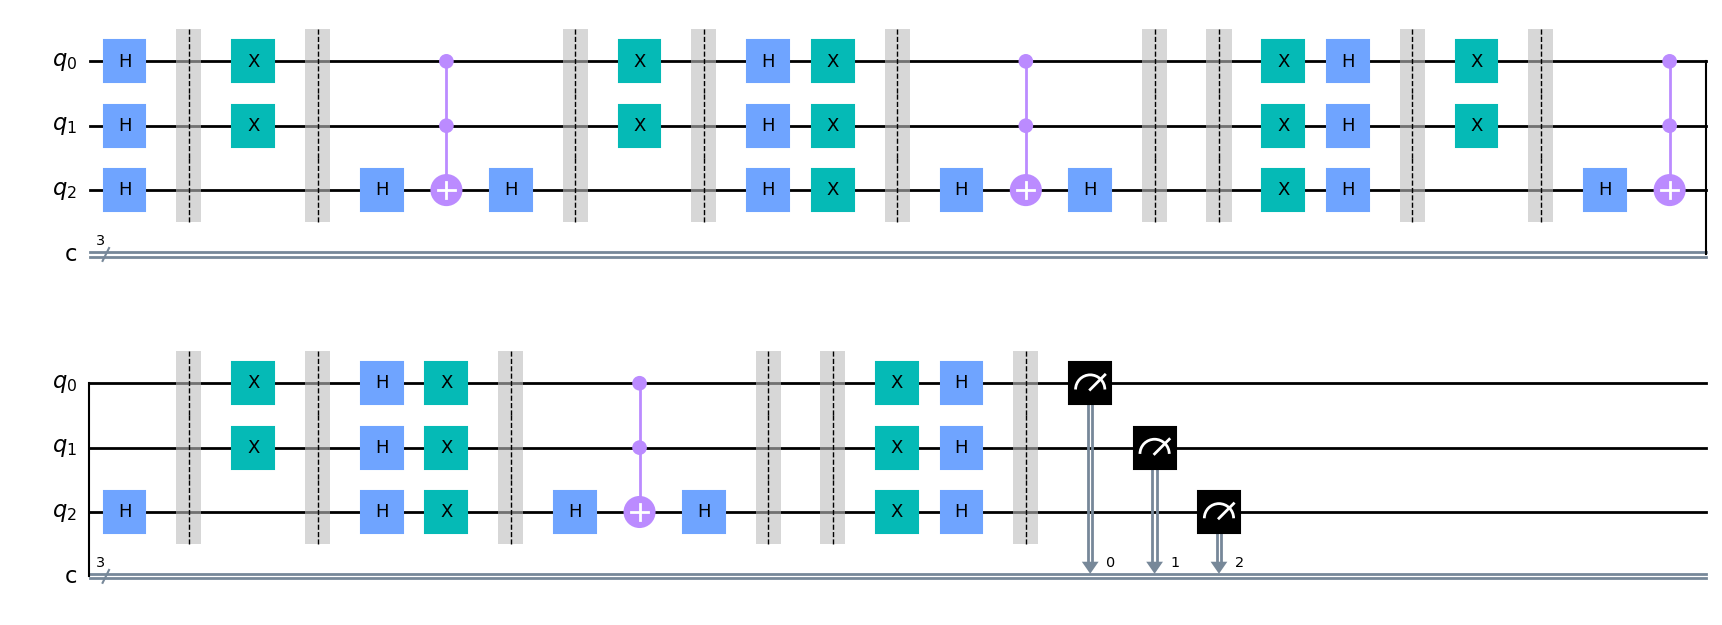

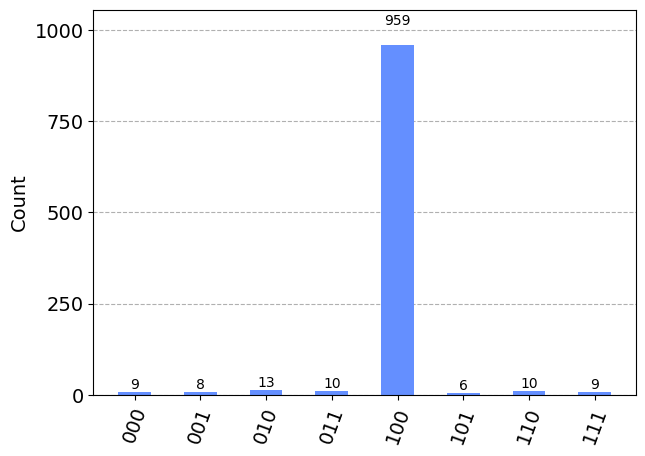

In [10]:
import numpy as np
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, assemble
from qiskit.visualization import plot_histogram

state = 0 | 1
count = int
qubit = int
QubitState = list[state]
counts = dict[str(QubitState): count]

def entangle_circuit(qc: QuantumCircuit)-> QuantumCircuit:
    num_qbits = len(qc.qubits)
    for qubit in range(num_qbits):
        qc.h(qubit)
    qc.barrier()
    return qc


def create_grover_circuit(seeked_state: QubitState, num_grover_iteration = 0)-> QuantumCircuit: # seeked_qubit is a string that represent the qubit we're looking for
    seeked_state.reverse() # We reverse because of Qiskit implementation of quantum circuit
    num_qbits = len(seeked_state)
    qc = QuantumCircuit(num_qbits, num_qbits)

    entangle_circuit(qc)    

    if not num_grover_iteration:
        # The number of diffuser to create depend of the number of qubits
        num_grover_iteration= np.floor(np.sqrt(2**num_qbits)) 

    for iteration in range(int(num_grover_iteration)):
        create_oracle(qc, seeked_state)
        create_diffuser(qc, num_qbits)

    return qc, 

def mark_seeked_state(qc: QuantumCircuit, seeked_state: QubitState)-> QuantumCircuit:
    for qubit, state in enumerate(seeked_state): 
        if state == 0:
            qc.x(qubit)
    qc.barrier()
    return qc



def create_oracle(qc: QuantumCircuit, seeked_state: QubitState)-> QuantumCircuit:
    
    mark_seeked_state(qc, seeked_state)
    last_qubit : qubit = len(qc.qubits)-1
    create_CCZgate(qc, target=last_qubit)
    mark_seeked_state(qc, seeked_state)
    return qc


def create_diffuser(qc, n):
    for i in range(n):
        qc.h(i)
    for i in range(n):
        qc.x(i)
    qc.barrier()
    last_qubit : qubit = n-1
    create_CCZgate(qc, target=last_qubit)
    qc.barrier()
    for i in range(n):
        qc.x(i)
    for i in range(n):
        qc.h(i)

    qc.barrier()
    return qc

def measure_circ(qc):
    num_qubits = len(qc.qubits)
    for i in range(num_qubits):
        qc.measure(i,i)
    aer_sim = Aer.get_backend('aer_simulator')
    qobj = assemble(qc, aer_sim)
    results = aer_sim.run(qobj).result()
    counts = results.get_counts()

    return counts


def create_CCZgate(qc: QuantumCircuit, target: qubit)-> QuantumCircuit: 
    qc.h(target)
    qc.mct(list(range(target)),target)
    qc.h(target)
    qc.barrier()
    return qc



qc = create_grover_circuit([1,0,0]) # we're looking for |100>
counts = measure_circ(qc)
display(qc.draw('mpl'))
display(plot_histogram(counts))

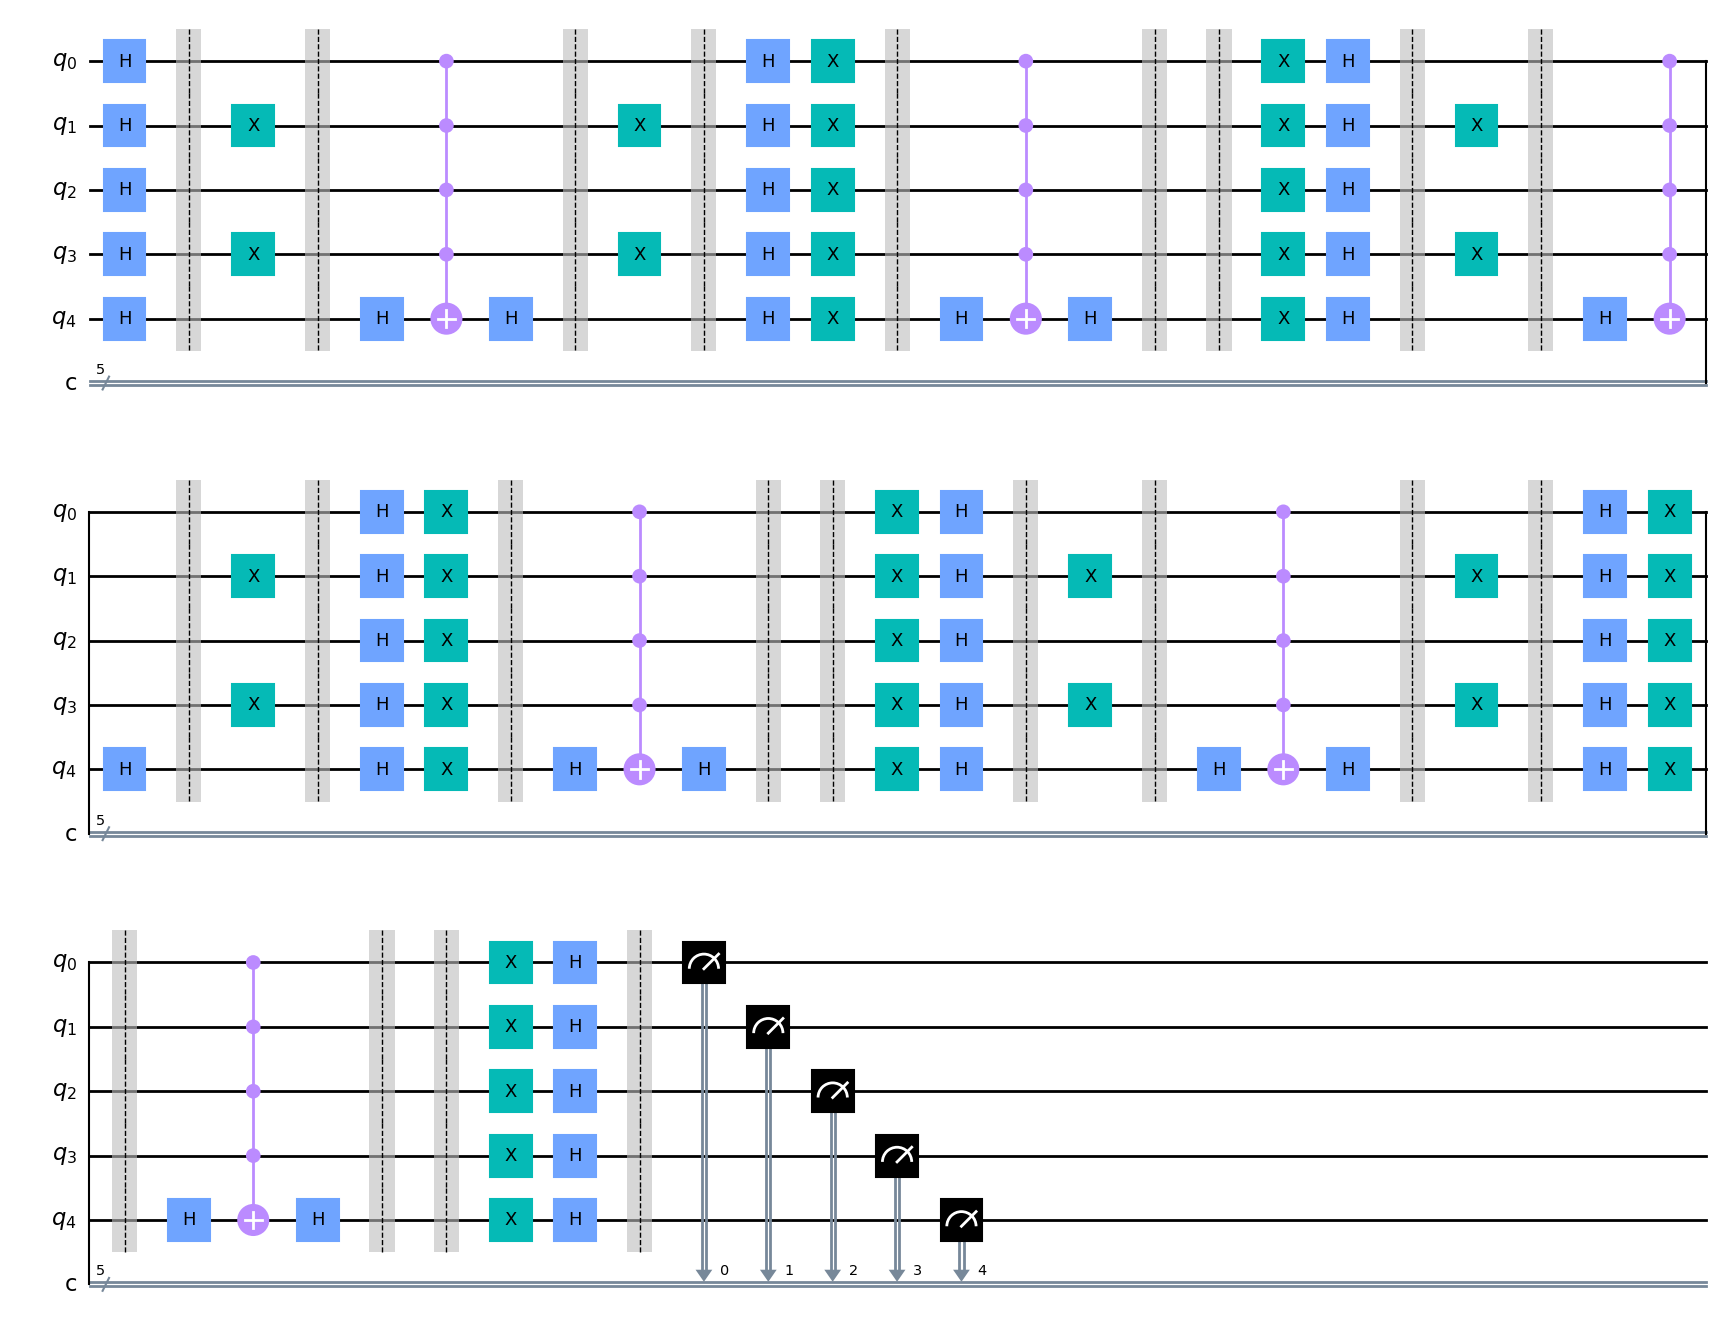

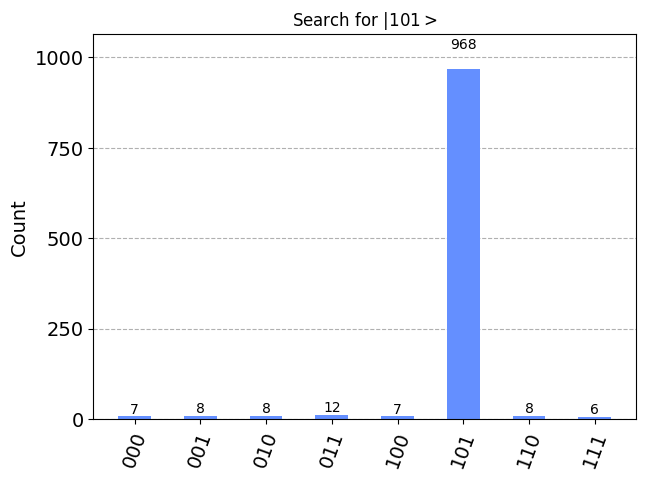

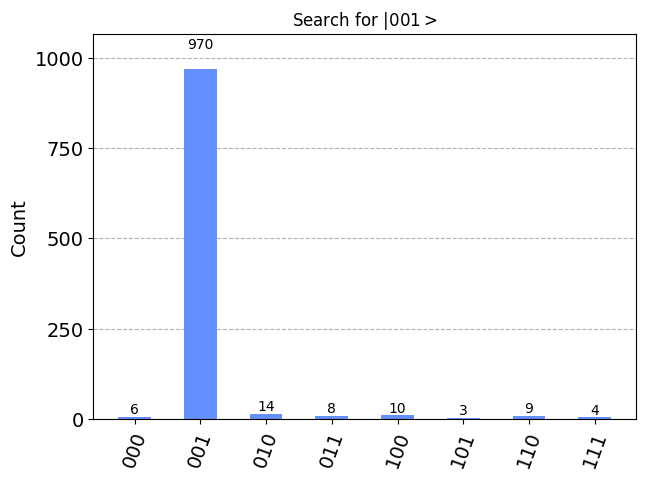

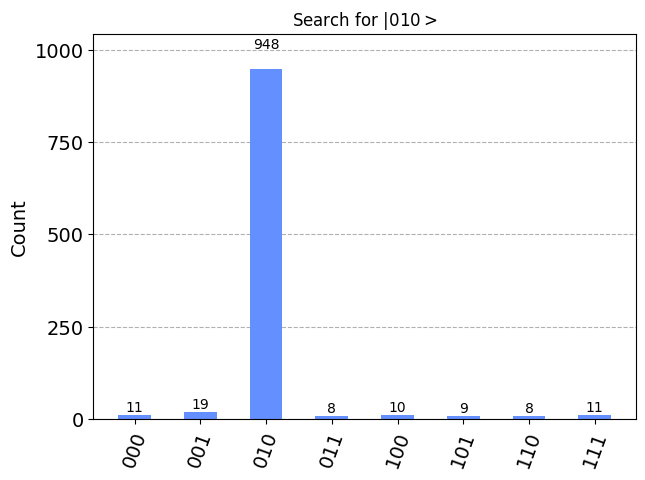

In [21]:
# Find 101, 001 and 010 :
qc1 = create_grover_circuit([1,0,1])
display(qc.draw('mpl'))
counts1 = measure_circ(qc1)
display(plot_histogram(counts1, title="Search for $|101>$"))
qc2 = create_grover_circuit([0, 0, 1])
counts2 = measure_circ(qc2)
display(plot_histogram(counts2, title="Search for $|001>$"))
qc3 = create_grover_circuit([0, 1, 0])
counts3 = measure_circ(qc3)
display(plot_histogram(counts3, title="Search for $|010>$"))

#### 3. Combien d'itérations de l'algorithme de Grover il faut exécuter pour trouver l'état |10101> ?

Pour touver avec précision un état de qubit, on a besoin de d'itérer plusieurs fois en fonction du nombre de qubits. Ici on a $n=5$, et on le nombre d'itération pour $\sqrt{2^n} $ .  D'où $\sqrt{2^5} \approx 5  $ on doit donc itérer 5 fois l'opérateur de Grover.

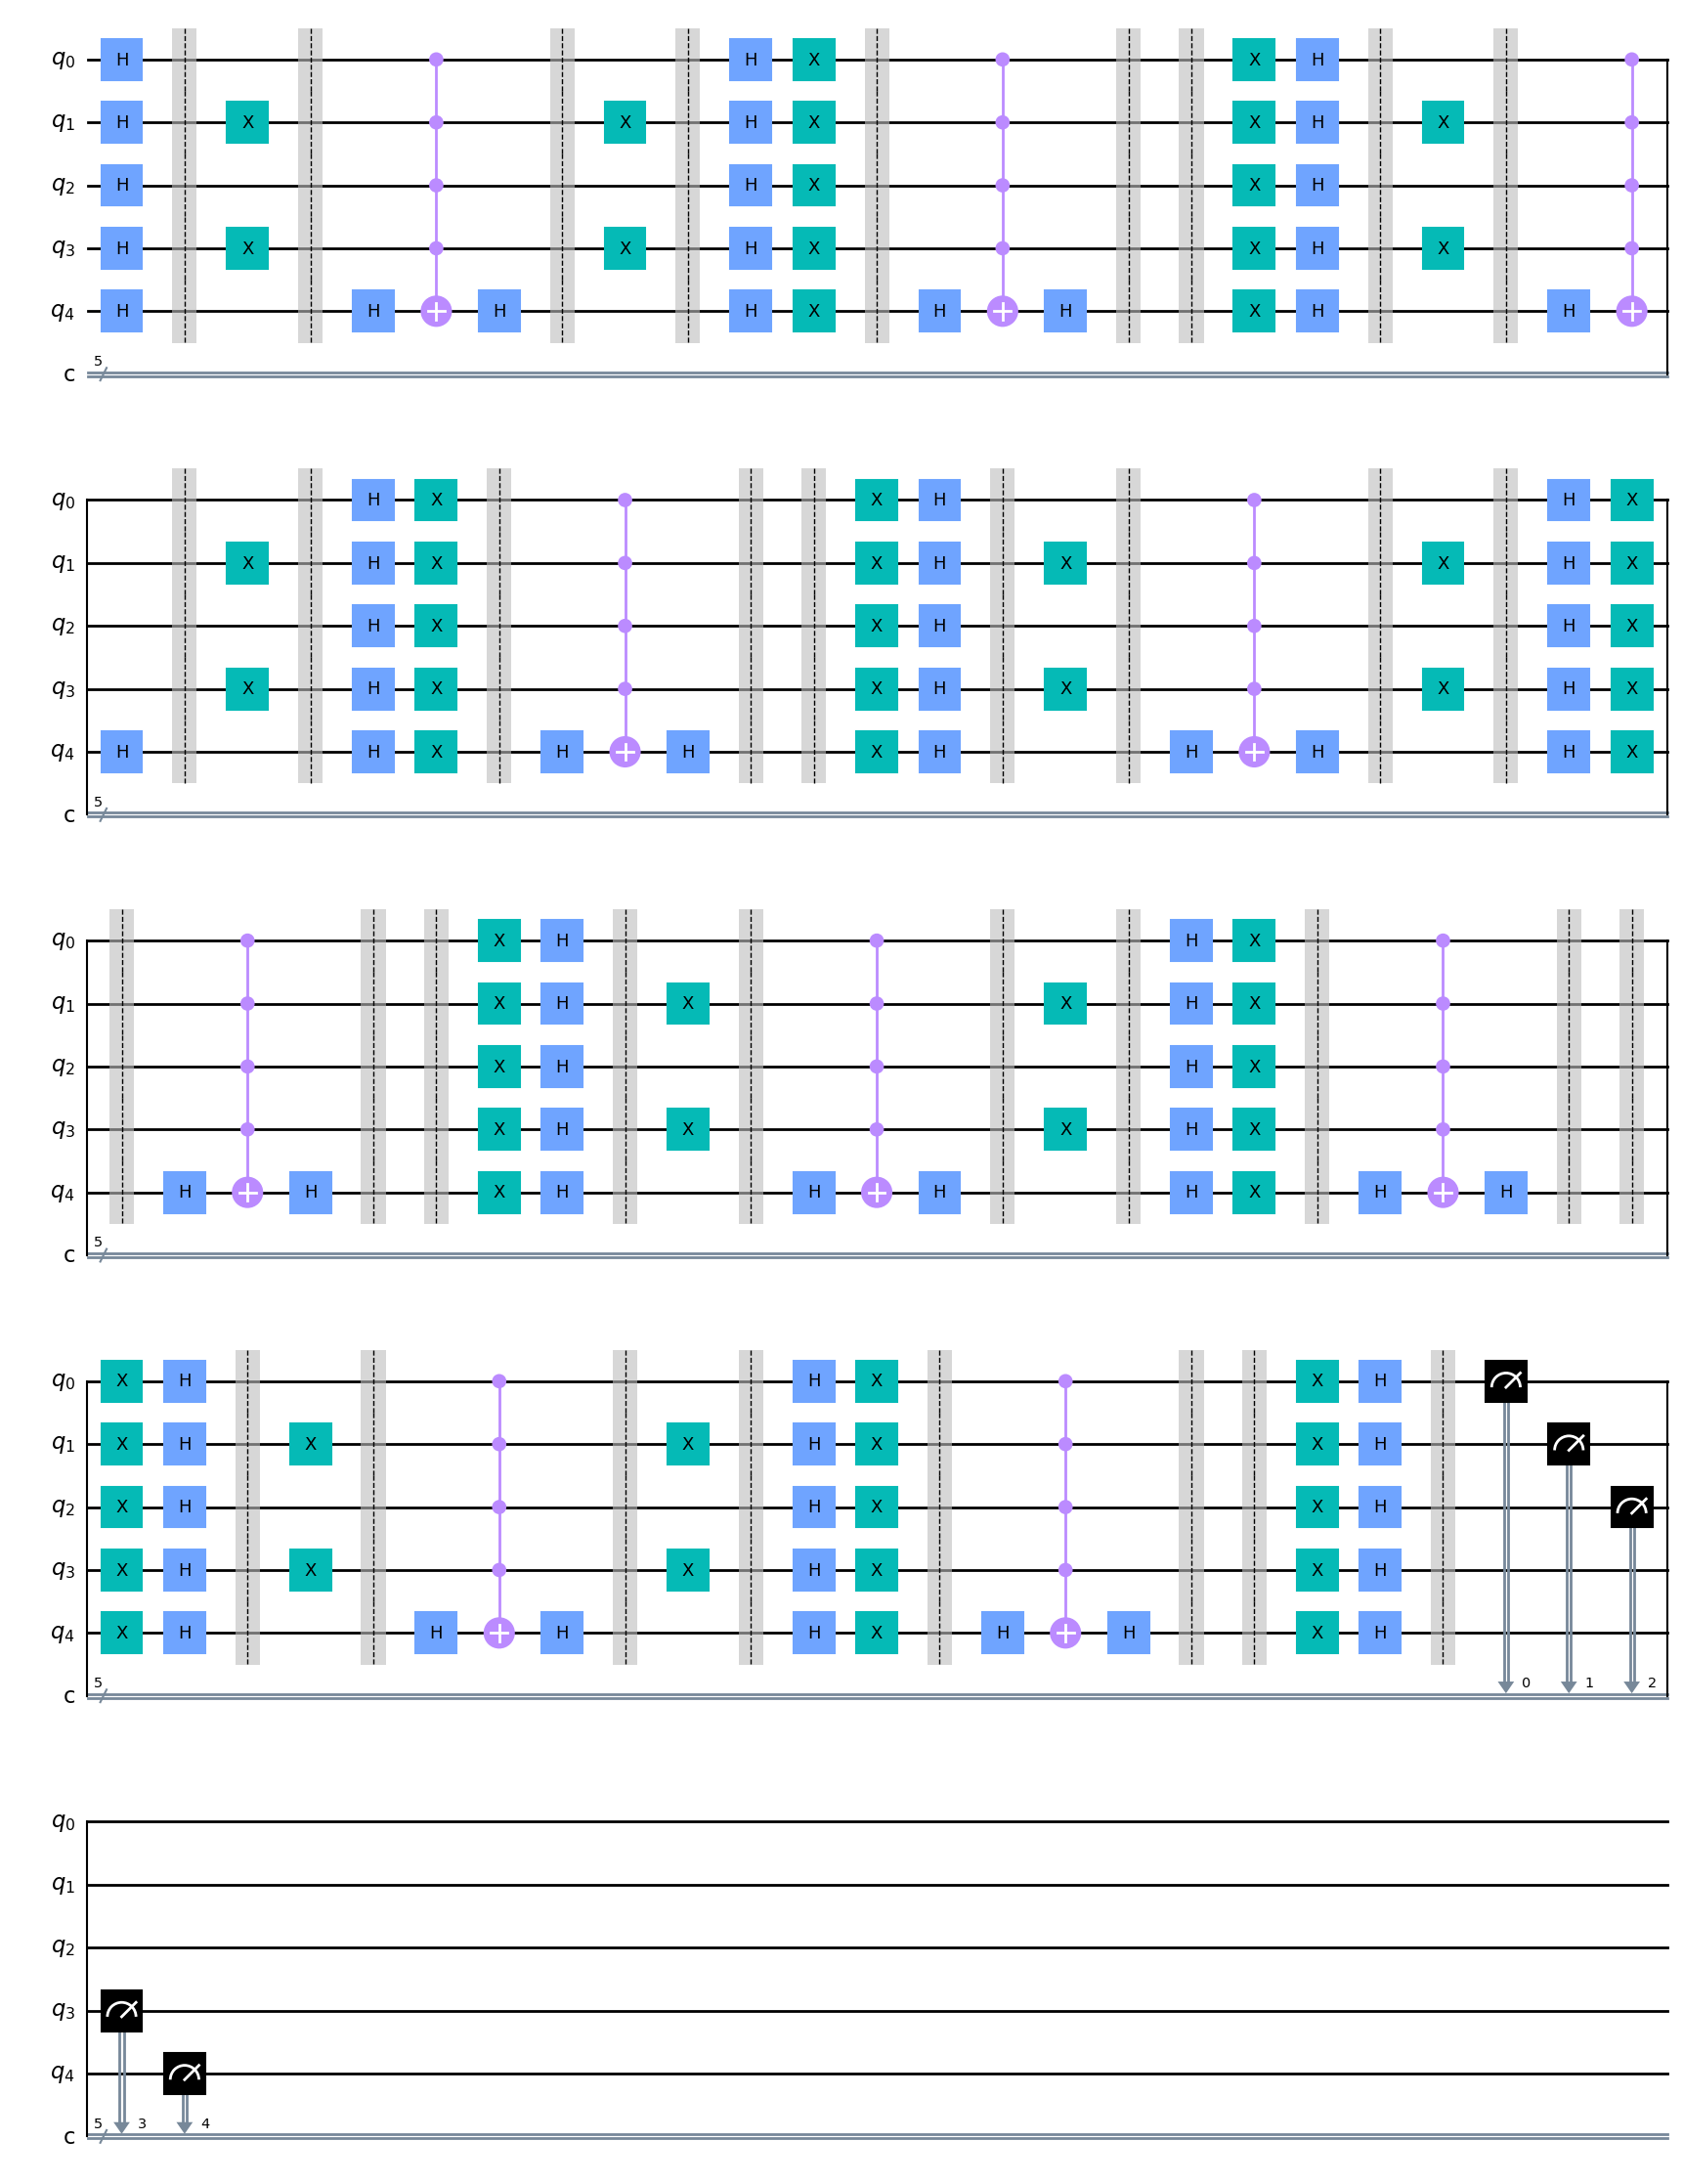

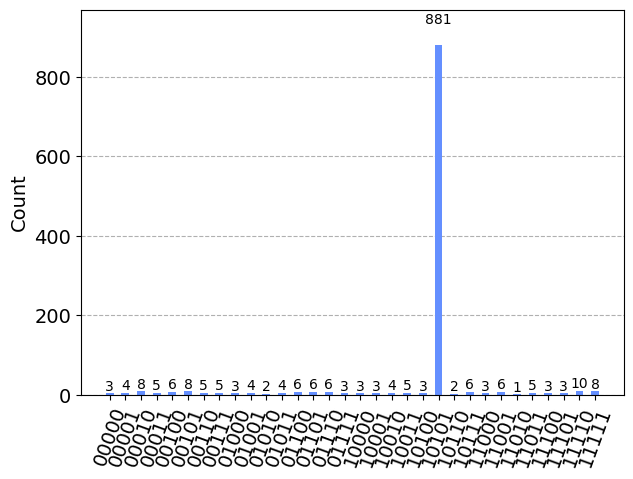

In [13]:
qc = create_grover_circuit([1, 0, 1, 0, 1])
counts = measure_circ(qc)
display(qc.draw('mpl'))
display(plot_histogram(counts))

#### Avec 1 itérations :
- Pour rechercher $\ket{10101} $:

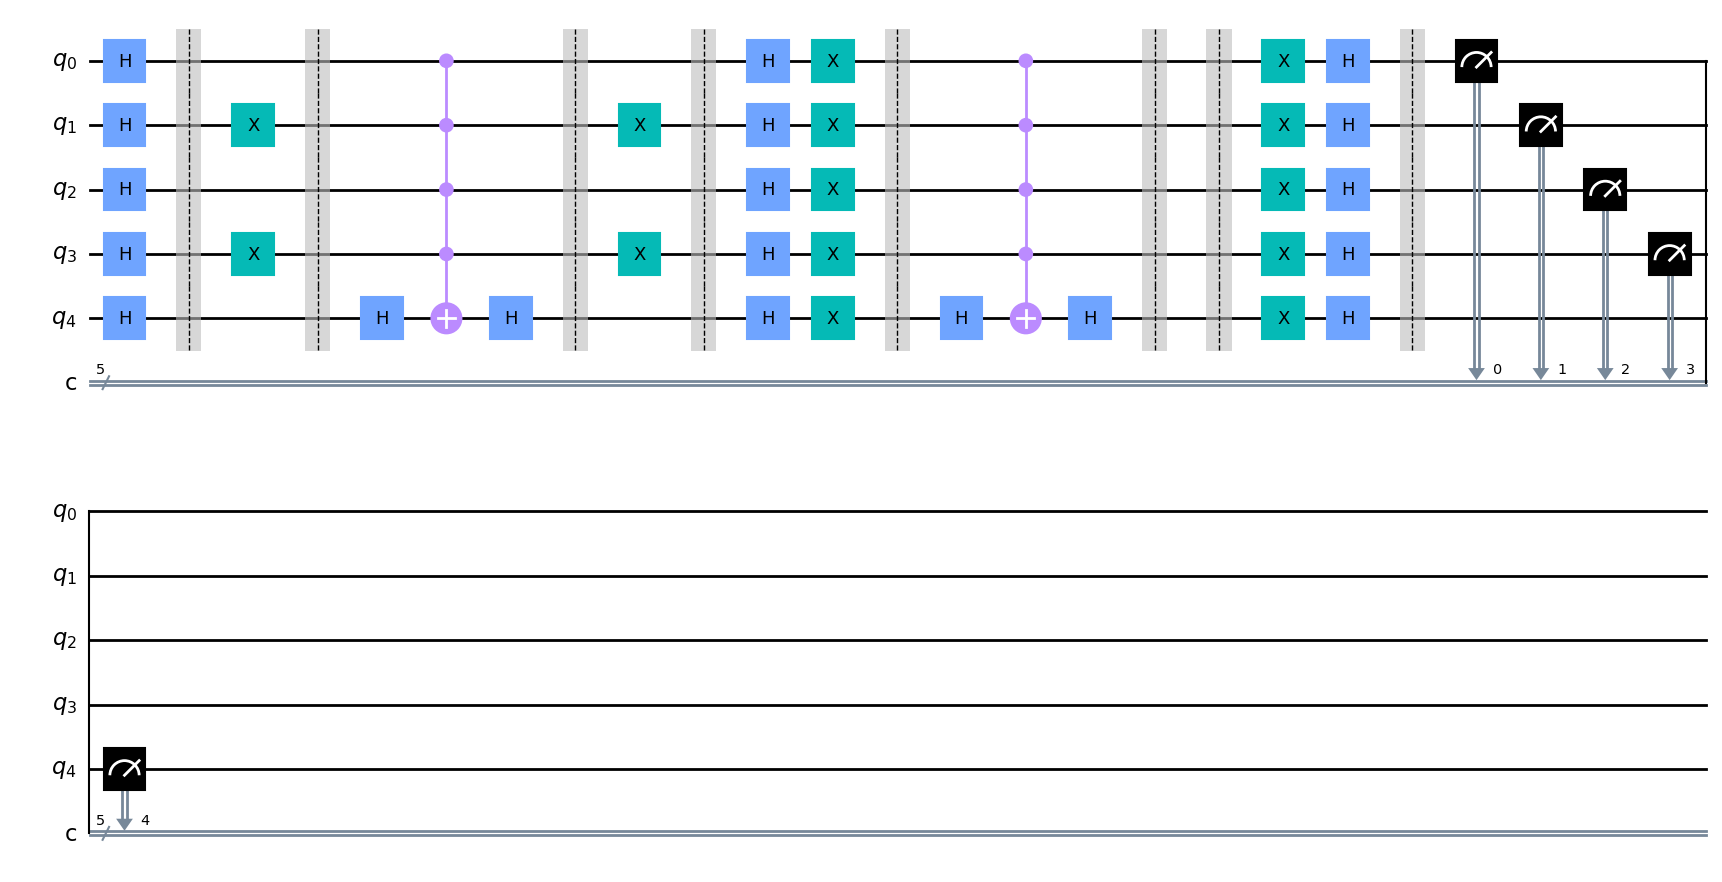

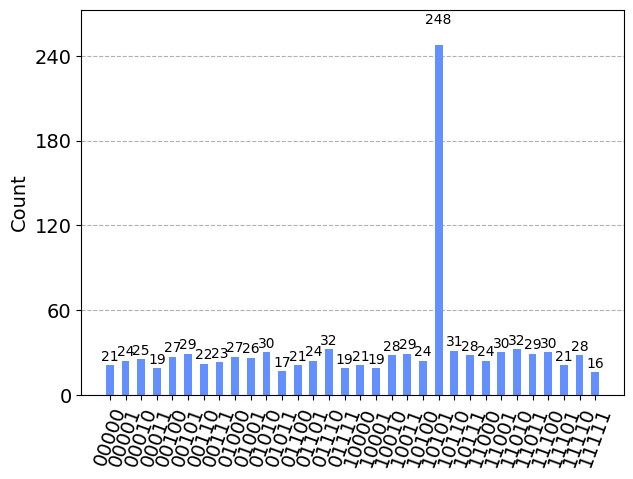

In [22]:
qc = create_grover_circuit([1, 0, 1, 0, 1], num_grover_iteration=1)
counts = measure_circ(qc)
display(qc.draw('mpl'))
display(plot_histogram(counts))

On voit que le résultat obtenu est certes plutôt préçis mais quand même bien moins que lorsque que l'on fait 5 itérations. Si on l'execute encore une autre fois on s'attend à avoir un résultat plus préçis.
- Recherche $\ket{10101}$ avec 3 itérations

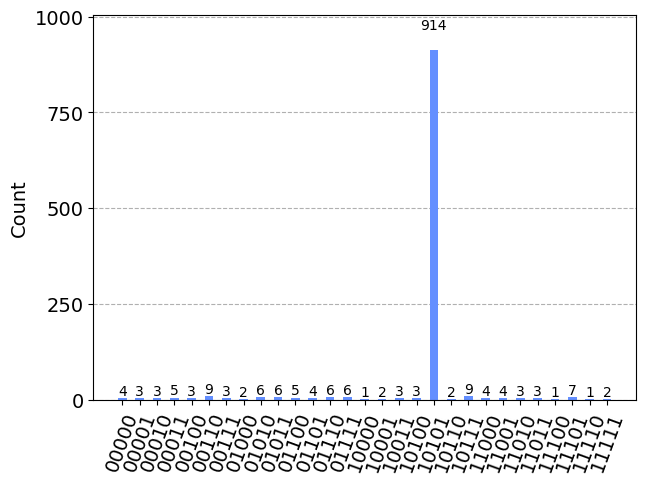

In [18]:
qc = create_grover_circuit([1, 0, 1, 0, 1], num_grover_iteration=3)
counts = measure_circ(qc)
display(plot_histogram(counts))